In [2]:
# imports 


import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy
from torchvision import transforms
import torch
import csv
import random
import numpy as np
from PIL import Image 
from tqdm import tqdm

import sys
sys.path.append(r'/home/afroehli/coding/util_scripts')
from utils_dataloading.dassl_datum_mod import DatumWithWnid 
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

sys.path.append(r'/home/afroehli/coding/OOD-X-Benchmarks')
from datasets import imagenet_x as i_x, imagenet_r_x as r_x, imagenet_c_x as c_x, imagenet_v2_x as v2_x

# other setup
random.seed(3)

In [3]:
# load datasets
results_available = True 

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_r_sorted.pkl', 'rb') as pickle_file: 
    imagenet_r_sorted = pickle.load(pickle_file)

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_x_sorted.pkl', 'rb') as pickle_file: 
    imagenet_x_sorted = pickle.load(pickle_file)

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_x_small_sorted.pkl', 'rb') as pickle_file: 
    imagenet_x_small_sorted = pickle.load(pickle_file)


# load model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()
dinov2_vits14.to(device)

transform = transforms.Compose([transforms.Resize((154, 210)),
                                transforms.ToTensor()])


# load semantic-info object
with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'rb') as pkl_file:
    semantic_info = pickle.load(pkl_file)


# load classes that are common in all imagenet variances 
wnids_common_classes = set()
with open('/home/afroehli/coding/dinov2_ood/storage/union_set_classes.txt', 'r') as union_file: 
    for line in union_file.readlines():
        common_wnid = line.rstrip('\n')
        wnids_common_classes.add(common_wnid)

print(f'Common classes found: {len(wnids_common_classes)}')
for n, common_class_wnid in enumerate(wnids_common_classes): 
    print(f'{n + 1}: {semantic_info.wnid_to_classname[common_class_wnid]}') 

# only in case model output was stored before
# load already calculated embeddings
if results_available:
    with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'rb') as pickle_file:
        imagenet_x_val_results = pickle.load(pickle_file)
    print(f'Number of precomputed classes of Imagenet-X-Val: {len(imagenet_x_val_results)}')
else:
    print('No precomputed classed of Imagenet-X-Val were loaded.')



Device used: cuda


Using cache found in /home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Common classes found: 135
1:  hippopotamus
2:  king penguin
3:  castle
4:  great egret
5:  jellyfish
6:  chimpanzee
7:  clownfish
8:  hummingbird
9:  canoe
10:  Rottweiler
11:  Yorkshire Terrier
12:  snow leopard
13:  French Bulldog
14:  cottontail rabbit
15:  leopard
16:  hyena
17:  giant panda
18:  Toy Poodle
19:  basketball
20:  goldfish
21:  mobile phone
22:  hammerhead shark
23:  gibbon
24:  junco
25:  monarch butterfly
26:  centipede
27:  Golden Retriever
28:  Chow Chow
29:  Shih Tzu
30:  barn
31:  cheetah
32:  cockroach
33:  German Shepherd Dog
34:  lighthouse
35:  carousel
36:  West Highland White Terrier
37:  scorpion
38:  Chihuahua
39:  Italian Greyhound
40:  killer whale
41:  snail
42:  zebra
43:  pig
44:  smooth newt
45:  tarantula
46:  tree frog
47:  fly
48:  sea lion
49:  candle
50:  red fox
51:  koala
52:  porcupine
53:  ladybug
54:  duck
55:  Afghan Hound
56:  starfish
57:  fox squirrel
58:  goldfinch
59:  gorilla
60:  toucan
61:  bathtub
62:  stingray
63:  Pembroke Wel

In [ ]:
# compute closest class for each common class 

# for each common-class, find closest class in rest of imagenet-1k (999 candidates)

common_class_comparisons = dict()
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected common-wnids: {len(wnids_common_classes)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for common_wnid in wnids_common_classes:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[common_wnid], axis=0)

    imagenet_wnids.remove(common_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            common_class_comparisons[common_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            common_class_comparisons[common_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    common_class_comparisons[common_wnid].sort(key = lambda ood_id: ood_id[0])
    imagenet_wnids.append(common_wnid)

Number of detected common-wnids: 135
Number of detected imagenet-wnids: 1000


In [7]:
# control output of closest classes 

for n, common_wnid in enumerate(common_class_comparisons.keys()):

    top_three = common_class_comparisons[common_wnid][:3]
    top_three_names = [(semantic_info.wnid_to_classname[tt_wnid], tt_score) for tt_score, tt_wnid in top_three]
    print(f'{n}: CC-Class = {semantic_info.wnid_to_classname[common_wnid]}, Next classes = {top_three_names}')

0: CC-Class =  chimpanzee, Next classes = [(' gorilla', np.float32(235.94043)), (' siamang', np.float32(286.9928)), (' orangutan', np.float32(309.70462))]
1: CC-Class =  Basset Hound, Next classes = [(' Beagle', np.float32(261.91693)), (' Treeing Walker Coonhound', np.float32(276.79465)), (' English foxhound', np.float32(339.79163))]
2: CC-Class =  giant panda, Next classes = [(' American black bear', np.float32(472.17554)), (' sloth bear', np.float32(484.3158)), (' brown bear', np.float32(489.51086))]
3: CC-Class =  Pomeranian, Next classes = [(' Chow Chow', np.float32(366.84155)), (' Pekingese', np.float32(401.38516)), (' Keeshond', np.float32(410.54218))]
4: CC-Class =  beaver, Next classes = [(' otter', np.float32(317.88696)), (' marmot', np.float32(359.8711)), (' mink', np.float32(389.43878))]
5: CC-Class =  Cocker Spaniel, Next classes = [(' Irish Setter', np.float32(292.4155)), (' Sussex Spaniel', np.float32(298.002)), (' Clumber Spaniel', np.float32(362.87933))]
6: CC-Class =  

In [10]:
# store class split 

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for common_wnid in common_class_comparisons.keys():
        closest_class_wnid = common_class_comparisons[common_wnid][0][1]
        split_writer.writerow([common_wnid, closest_class_wnid])


In [4]:
# load class pairs 

closest_classes = set() 
    

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'r')as class_split_table:
    split_reader = csv.reader(class_split_table, delimiter=';')
    for n, table_row in enumerate(split_reader):
        class_1 = table_row[0]
        class_2 = table_row[1]
        new_combination = (class_1, class_2)
        closest_classes.add(new_combination)



In [5]:
# util functions  

def get_random_class() -> str:
    all_classes = list(imagenet_x_sorted.keys())
    n_classes = len(all_classes)
    next_int = random.randint(0, n_classes - 1)
    next_class = all_classes[next_int]

    return next_class

In [6]:
# variables for later use

ood_id_random_combination = []
random_compare_set = dict()

In [ ]:
# calculate embedding for new classes 

# random_set_size = 10 

all_imagenet_classes = list(imagenet_x_sorted.keys())
new_class_processed = 0

for wnid in tqdm(all_imagenet_classes):
# for it, ood_id_pair in enumerate(class_splits): 

#     ood_wnid, id_wnid = ood_id_pair 
#     random_class_wnid = get_random_class()
#     random_set = [get_random_class() for i in range(0, random_set_size)]

#     ood_id_random_combination.append((ood_wnid, id_wnid, random_class_wnid))
#     random_compare_set[(ood_wnid, id_wnid, random_class_wnid)] = copy.deepcopy(random_set)

#     print(f'Iteration {it}. Next triple processed: {semantic_info.wnid_to_classname[ood_wnid]}',
#           f', {semantic_info.wnid_to_classname[id_wnid]}, {semantic_info.wnid_to_classname[random_class_wnid]}.\n'
#           f'Random-compare-set: {[semantic_info.wnid_to_classname[random_wnid] for random_wnid in random_set]}.')
    
    
#     image_processed = 0
    
#     wnid_set = [ood_wnid, id_wnid, random_class_wnid]
#     wnid_set.extend(random_set)
#     for wnid in wnid_set:

        covered_classes = list(imagenet_x_val_results.keys())
        
        if not wnid in covered_classes:
            for dassl_instance in imagenet_x_sorted[wnid]:

                pic_data = transform(Image.open(dassl_instance.impath).convert('RGB')).unsqueeze(0)
                pic_data_cuda = pic_data.to(device)

                model_out = dinov2_vits14(pic_data_cuda)
                try: 
                    imagenet_x_val_results[wnid].append(model_out.cpu().data.numpy()[0])
                except KeyError:
                    imagenet_x_val_results[wnid] = [model_out.cpu().data.numpy()[0]]

        else:
            print(f'Class *{semantic_info.wnid_to_classname[wnid]}* is already covered.')
            
        new_class_processed += 1

print(f'New classes were processed: {new_class_processed}')

In [46]:
# store calculated classes

with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_x_val_results, pickle_file, pickle.HIGHEST_PROTOCOL)

In [9]:
statistics_dict = dict()

## calculate statistics 

# general statistics on whole imagenet dataset 
# np-array with shape 1000 x 50 x 384
results_all_classes = np.array([imagenet_x_val_results[class_wnid] for class_wnid in imagenet_x_val_results.keys()])

mean_pictures_all_classes = np.mean(results_all_classes, axis=1)
# shape 1000 x 384
mean_classes_all_classes = np.mean(mean_pictures_all_classes, axis=0)
mean_imagenet = mean_classes_all_classes
# shape 384

for inv_class, comp_class in closest_classes: 

    comb_key = (inv_class, comp_class)

    # select random compare class
    ran_comp_class = get_random_class()
    while ran_comp_class == inv_class or ran_comp_class == comp_class:
        ran_comp_class = get_random_class()

    statistics_dict[comb_key] = dict()
    statistics_dict[comb_key]['ran_comp_class'] = ran_comp_class 

    inv_class_res = np.array(imagenet_x_val_results[inv_class])
    comp_class_res = np.array(imagenet_x_val_results[comp_class])
    ran_comp_class_res = np.array(imagenet_x_val_results[ran_comp_class])


    inv_class_mean = np.mean(inv_class_res, axis=0)
    comp_class_mean = np.mean(comp_class_res, axis=0)
    ran_comp_class_mean = np.mean(ran_comp_class_res, axis=0)
    
    inv_class_std = np.std(inv_class_res, axis=0)
    comp_class_std = np.std(comp_class_res, axis=0)
    ran_comp_class_std = np.std(ran_comp_class_res, axis=0)
    
    diff_comp_inv = np.abs(comp_class_mean - inv_class_mean)
    diff_ran_comp_inv = np.abs(ran_comp_class_mean - inv_class_mean)
    diff_imagenet_inv = np.abs(mean_imagenet - inv_class_mean)

    statistics_dict[comb_key] = dict()
    statistics_dict[comb_key]['counts'] = dict()
    statistics_dict[comb_key]['inSTD'] = dict()
    statistics_dict[comb_key]['sum'] = dict()

    # count dimensions where mean of class1 is nearer than of class2 
    true_false_list = (diff_comp_inv < diff_ran_comp_inv).tolist()
    comp_is_nearer = true_false_list.count(True)
    statistics_dict[comb_key]['counts']['comp-ranComp'] = comp_is_nearer 

    true_false_list = (diff_comp_inv < diff_imagenet_inv).tolist()
    comp_is_nearer_imagenet = true_false_list.count(True)
    statistics_dict[comb_key]['counts']['comp-inet'] = comp_is_nearer_imagenet 

    # count dimensions where mean of class1 lies within std of inv-class
    true_false_list = (diff_comp_inv < inv_class_std).tolist()
    comp_within_std = true_false_list.count(True)
    statistics_dict[comb_key]['inSTD']['comp'] = comp_within_std

    true_false_list = (diff_ran_comp_inv < inv_class_std).tolist()
    random_within_std = true_false_list.count(True)
    statistics_dict[comb_key]['inSTD']['ranComp'] = random_within_std

    true_false_list = (diff_imagenet_inv < inv_class_std).tolist()
    imagenet_within_std = true_false_list.count(True)
    statistics_dict[comb_key]['inSTD']['inet'] = imagenet_within_std

    # sum of p1-distance over all dimensions
    statistics_dict[comb_key]['sum']['comp'] = np.sum(diff_comp_inv)
    statistics_dict[comb_key]['sum']['ranComp'] = np.sum(diff_ran_comp_inv)
    statistics_dict[comb_key]['sum']['inet'] = np.sum(diff_imagenet_inv)



In [12]:
# prepare statistics 

all_combinations = list(statistics_dict.keys())
comb_mapping = dict()
for n, comb in enumerate(all_combinations):
    comb_mapping[n] = comb 

all_combinations_numbers = list(comb_mapping.keys())

# data for utilizing visualization

fifty_percent = [50 for i in range(0, len(all_combinations))]
fifty_percent_df = pd.DataFrame(data=list(zip(all_combinations_numbers, fifty_percent)), columns=['Comb', 'Val'])
fifty_percent_df['Rel'] = '50%'

# generating dataframes for visualizing smaller distance counts
count_comp_ranComp = [(statistics_dict[combination]['counts']['comp-ranComp'] / 384) * 100 for combination in all_combinations]
count_comp_inet = [(statistics_dict[combination]['counts']['comp-inet'] / 384) * 100 for combination in all_combinations]

count_comp_ranComp_df = pd.DataFrame(data=list(zip(all_combinations_numbers, count_comp_ranComp)), columns=['Comb', 'Val'])
count_comp_ranComp_df['Rel'] = 'comp-ranComp'

count_comp_inet_df = pd.DataFrame(data=list(zip(all_combinations_numbers, count_comp_inet)), columns=['Comb', 'Val'])
count_comp_inet_df['Rel'] = 'comp-inet'

# generating dataframes for visualizing sum over distances per dimension
comp_sum_diff = [statistics_dict[combination]['sum']['comp'] for combination in all_combinations]
mean_comp_sum_diff = [sum(comp_sum_diff) / 135 for i in range(0, 135)]
comp_sum_diff_df = pd.DataFrame(data = list(zip(all_combinations_numbers, comp_sum_diff, mean_comp_sum_diff)), 
                                columns=['Comb', 'Sum', 'MeanSum'])
comp_sum_diff_df['Rel'] = 'comp'
# id_sum_diff_mean = [sum(id_sum_diff_ood) / len(id_sum_diff_ood) for i in range(0, 40)]
# id_sum_diff_lower_half = sorted(id_sum_diff_ood)[:20]
# id_sum_lower_half_mean = [sum(id_sum_diff_lower_half) / 20 for i in range(0, 40)]

ranComp_sum_diff = [statistics_dict[combination]['sum']['ranComp'] for combination in all_combinations]
mean_ranComp_sum_diff = [sum(ranComp_sum_diff) / 135 for i in range(0, 135)]
ranComp_sum_diff_df = pd.DataFrame(data = list(zip(all_combinations_numbers, ranComp_sum_diff, mean_ranComp_sum_diff)),
                                   columns=['Comb', 'Sum', 'MeanSum'])
ranComp_sum_diff_df['Rel'] = 'ranComp'
# random_sum_diff_mean = [sum(random_sum_diff_ood) / len(random_sum_diff_ood) for i in range(0, 40)]

inet_sum_diff = [statistics_dict[combination]['sum']['inet'] for combination in all_combinations]
mean_inet_sum_diff = [sum(inet_sum_diff)/135 for i in range(0, 135)]
inet_sum_diff_df = pd.DataFrame(data = list(zip(all_combinations_numbers, inet_sum_diff, mean_inet_sum_diff)), 
                                columns=['Comb', 'Sum', 'MeanSum'])
inet_sum_diff_df['Rel'] = 'inet'

# random_comp_sum_diff_mean = [sum(random_comp_sum_diff_ood) / len(random_comp_sum_diff_ood) for i in range(0, 40)]
# ran_comp_diff_lower_half = sorted(random_comp_sum_diff_ood)[:20]
# ran_comp_lower_half_mean = [sum(ran_comp_diff_lower_half) / 20 for i in range(0, 40)]

# pd dataframes

diff_counts_df = pd.concat([count_comp_ranComp_df, count_comp_inet_df, fifty_percent_df], ignore_index=True)
diff_sum_df = pd.concat([comp_sum_diff_df, ranComp_sum_diff_df, inet_sum_diff_df], 
                           ignore_index=True)

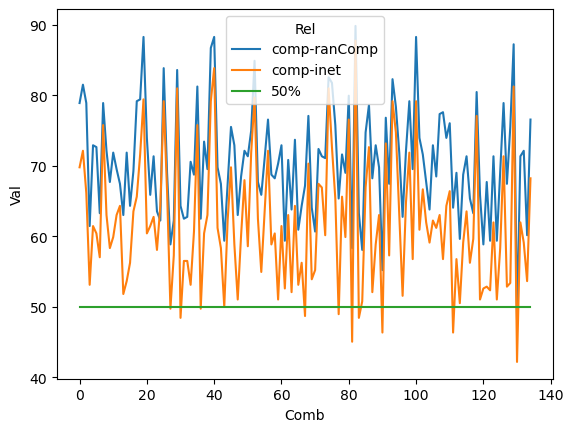

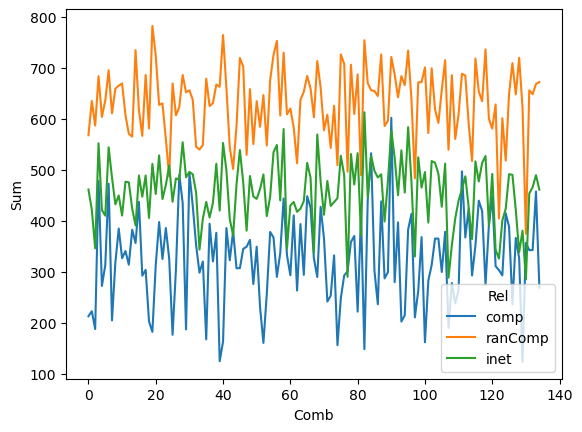

,Comb,Sum,MeanSum,Rel
0,0,212.599854,324.660034,comp
1,1,222.274002,324.660034,comp
2,2,187.459229,324.660034,comp
3,3,477.739807,324.660034,comp
4,4,271.856140,324.660034,comp


,Comb,Rel,Measure,value
0,0,comp,Sum,212.599854
1,1,comp,Sum,222.274002
2,2,comp,Sum,187.459229
3,3,comp,Sum,477.739807
4,4,comp,Sum,271.856140


,Comb,Rel,Measure,value,RelMeasure
0,0,comp,Sum,212.599854,compSum
1,1,comp,Sum,222.274002,compSum
2,2,comp,Sum,187.459229,compSum
3,3,comp,Sum,477.739807,compSum
4,4,comp,Sum,271.856140,compSum


<Axes: xlabel='Comb', ylabel='value'>

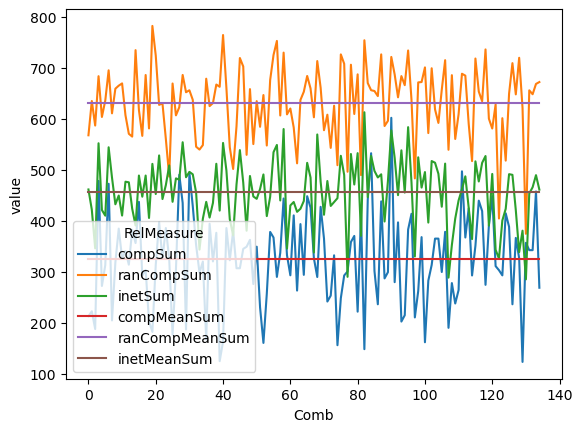

In [22]:
 # visualize statistics 


sns.lineplot(data=diff_counts_df, x='Comb', y='Val', hue='Rel')
plt.show()

sns.lineplot(data=diff_sum_df, x='Comb', y='Sum', hue='Rel')
plt.show()

display(diff_sum_df.head())
sum_mean_combined = diff_sum_df.melt(id_vars=['Comb', 'Rel'], var_name='Measure', value_vars=['Sum', 'MeanSum'])
display(sum_mean_combined.head())
sum_mean_combined['RelMeasure'] = sum_mean_combined['Rel'] + sum_mean_combined['Measure']
display(sum_mean_combined.head())

sns.lineplot(data=sum_mean_combined, x='Comb', y='value', hue='RelMeasure')

In [41]:
# identify 50% of worst id-ood matches regarding mean distance 
# 

sum_combination_dict = dict()

for combination in all_combinations:
    sum_combination_dict[float(statistics_dict[combination]['id_sum'])] = combination 

sorted_dict = sorted(sum_combination_dict)
print(sorted_dict)

worst_id_ood_matches = []
for p, diff_sum in enumerate(sorted_dict):

    ood_wnid, id_wnid, ran_wnid = sum_combination_dict[diff_sum]
    id_name = semantic_info.wnid_to_classname[id_wnid]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]

    print(f'{p}: Scored {diff_sum:.2e}: OOD = {ood_name}, ID = {id_name}')

print(f'Combinations printed: {len(sorted_dict)} from possible {len(all_combinations)} combinations.')

[285.52801513671875, 289.4336853027344, 292.9093017578125, 306.568359375, 309.7046203613281, 342.04351806640625, 364.65673828125, 364.68670654296875, 366.841552734375, 384.62213134765625, 399.7071838378906, 410.1962890625, 426.5854797363281, 427.532958984375, 434.56048583984375, 445.22161865234375, 470.74700927734375, 488.12548828125, 493.9937744140625, 502.389892578125, 508.62213134765625, 517.4906005859375, 528.6527099609375, 531.45068359375, 536.09912109375, 544.8900146484375, 554.5610961914062, 560.0919189453125, 565.3636474609375, 585.909912109375, 601.3419189453125, 618.6402587890625, 628.5443115234375, 641.086669921875, 641.65869140625, 643.666015625, 645.576904296875, 674.760986328125, 693.0130615234375, 693.08740234375]
0: Scored 2.86e+02: OOD =  Standard Poodle, ID =  Toy Poodle
1: Scored 2.89e+02: OOD =  cheetah, ID =  leopard
2: Scored 2.93e+02: OOD =  Whippet, ID =  Italian Greyhound
3: Scored 3.07e+02: OOD =  gorilla, ID =  orangutan
4: Scored 3.10e+02: OOD =  chimpanzee,

In [ ]:
# for each ood-class, find closest class in rest of imagenet-1k (999 candidates)

ood_class_comparisons = dict()
all_ood_wnids = [id_ood[0] for id_ood in class_splits]
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected ood-wnids: {len(all_ood_wnids)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for ood_wnid in all_ood_wnids:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[ood_wnid], axis=0)

    imagenet_wnids.remove(ood_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            ood_class_comparisons[ood_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            ood_class_comparisons[ood_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    ood_class_comparisons[ood_wnid].sort(key = lambda ood_id: ood_id[0])
    
    imagenet_wnids.append(ood_wnid)

Number of detected ood-wnids: 40
Number of detected imagenet-wnids: 1000
Total compare classes for n01616318: 999
Total compare classes for n02106550: 999
Total compare classes for n02096585: 999
Total compare classes for n02112137: 999
Total compare classes for n02091134: 999
Total compare classes for n02086240: 999
Total compare classes for n02056570: 999
Total compare classes for n02480855: 999
Total compare classes for n01534433: 999
Total compare classes for n02749479: 999
Total compare classes for n02108915: 999
Total compare classes for n02481823: 999
Total compare classes for n01694178: 999
Total compare classes for n02236044: 999
Total compare classes for n02423022: 999
Total compare classes for n02113799: 999
Total compare classes for n02814860: 999
Total compare classes for n01632777: 999
Total compare classes for n01986214: 999
Total compare classes for n02097298: 999
Total compare classes for n02098286: 999
Total compare classes for n02066245: 999
Total compare classes for

In [50]:
# print closest compare classes for each ood-class

for ood_wnid in all_ood_wnids: 

    top_five = ood_class_comparisons[ood_wnid][:5]
    top_five_names = [(semantic_info.wnid_to_classname[wnid], score) for score, wnid in top_five]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]
    print(f'OOD = {ood_name}: {top_five_names}')


OOD =  vulture: [(' bald eagle', np.float32(364.6867)), (' kite (bird of prey)', np.float32(374.1024)), (' hornbill', np.float32(427.8051)), (' ptarmigan', np.float32(438.59735)), (' black stork', np.float32(446.6934))]
OOD =  Rottweiler: [(' Black and Tan Coonhound', np.float32(247.84436)), (' Dobermann', np.float32(274.29382)), (' Miniature Pinscher', np.float32(354.40723)), (' Greater Swiss Mountain Dog', np.float32(369.6695)), (' Entlebucher Sennenhund', np.float32(377.0548))]
OOD =  Boston Terrier: [(' French Bulldog', np.float32(313.06226)), (' Staffordshire Bull Terrier', np.float32(401.3598)), (' Boxer', np.float32(438.5884)), (' American Staffordshire Terrier', np.float32(439.02612)), (' toy terrier', np.float32(443.41534))]
OOD =  Chow Chow: [(' Pomeranian', np.float32(366.84155)), (' Keeshond', np.float32(374.4064)), (' Samoyed', np.float32(429.12982)), (' Pekingese', np.float32(445.51138)), (' Great Pyrenees dog', np.float32(469.20425))]
OOD =  Whippet: [(' Ibizan Hound', n